1. To bulid a model with wine_data.csv to find the quality of the wine based on its chemical properties. We split the data in 80/20 to train and validate and printed teh accuracy and confusion matrix

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [5]:
# Load Data for training and testing
train_val_data = pd.read_csv('wine_data.csv')
test_data = pd.read_csv('wine_data_test.csv')

In [6]:
train_val_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,1
1,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,0
2,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,1
3,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,0
4,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,1


In [7]:
test_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.7,0.56,0.08,2.50,0.114,14,46,0.9971,3.24,0.66,9.6,1
1,7.8,0.50,0.17,1.60,0.082,21,102,0.9960,3.39,0.48,9.5,0
2,10.7,0.67,0.22,2.70,0.107,17,34,1.0004,3.28,0.98,9.9,1
3,8.5,0.46,0.31,2.25,0.078,32,58,0.9980,3.33,0.54,9.8,0
4,6.7,0.46,0.24,1.70,0.077,18,34,0.9948,3.39,0.60,10.6,1


In [8]:
print("Initial shape of train data:", train_val_data.shape)
print("Initial shape of test data:", test_data.shape)

Initial shape of train data: (1359, 12)
Initial shape of test data: (100, 12)


In [9]:
train_val_data.drop_duplicates(inplace=True)
print("Dropping duplicates of train data:", train_val_data.shape)
test_data.drop_duplicates(inplace=True)
print("Dropping duplicates of test data:", test_data.shape)

Dropping duplicates of train data: (1185, 12)
Dropping duplicates of test data: (100, 12)


There are few duplicates in the train dataset, dropped those duplicates data. No duplicates found in the test set.

In [10]:
print("\nMissing values of train data:\n", train_val_data.isnull().sum())
print("\nMissing values of test data:\n", test_data.isnull().sum())


Missing values of train data:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Missing values of test data:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


No Missing Values found.

In [11]:
X = train_val_data.drop(columns=["quality"])
y = train_val_data["quality"]

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Train-validation split (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print("Train data count:", len(X_train))
print("Validation data count:", len(X_val))

Train data count: 948
Validation data count: 237


In [14]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 4],
    'learning_rate': [0.05],
    'reg_alpha': [0.1, 1],
    'reg_lambda': [1, 10],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

In [15]:
# XGBoost model
xgb = XGBClassifier(eval_metric='logloss')

# Grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
xgboost = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [16]:
y_train_pred = xgboost.predict(X_train)
y_val_pred = xgboost.predict(X_val)

2. Testing the model with the wine_data_test.csv and printing the accuracy and confusion matrix

In [21]:
X_test = test_data.drop(columns=["quality"])
y_test = test_data["quality"]
X_test_scaled = scaler.transform(X_test)
y_test_pred = xgboost.predict(X_test_scaled)

In [22]:
train_cm = confusion_matrix(y_train, y_train_pred)
val_cm = confusion_matrix(y_val, y_val_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

In [29]:
def evaluate_and_plot(cm, dataset_name, y_true, y_pred):
    print(f"\n{dataset_name.upper()} SET:")
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


TRAIN SET:
Accuracy: 0.8534
Confusion Matrix:
 [[384  66]
 [ 73 425]]


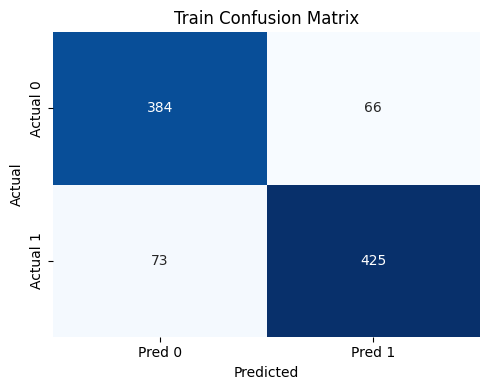

In [30]:
evaluate_and_plot(train_cm, "Train", y_train, y_train_pred)


VALIDATION SET:
Accuracy: 0.7637
Confusion Matrix:
 [[95 18]
 [38 86]]


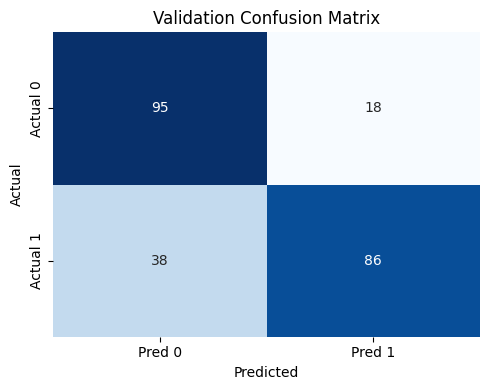

In [31]:
evaluate_and_plot(val_cm, "Validation", y_val, y_val_pred)


TEST SET:
Accuracy: 0.8700
Confusion Matrix:
 [[42  6]
 [ 7 45]]


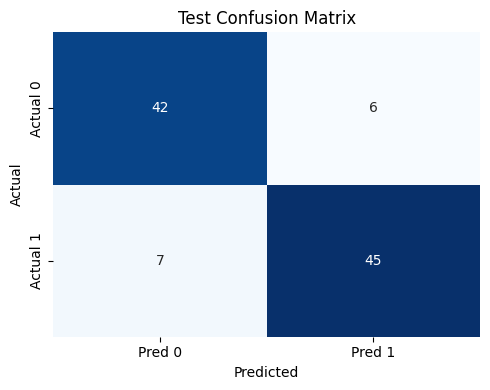

In [32]:
evaluate_and_plot(test_cm, "Test", y_test, y_test_pred)

3. Apply 10-fold stratified cross-validation. Print out the accuracy of each fold. Print out the average accuracy across all the folds.

In [34]:
if isinstance(y, pd.DataFrame):
    y = y.squeeze()

In [35]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

In [36]:
print("\n10-Fold Stratified Cross-Validation Results:")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y), start=1):
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    xgb.fit(X_train_fold, y_train_fold)
    y_pred = xgb.predict(X_val_fold)
    acc = accuracy_score(y_val_fold, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold}: Accuracy = {acc:.4f}")


10-Fold Stratified Cross-Validation Results:
Fold 1: Accuracy = 0.7983
Fold 2: Accuracy = 0.7395
Fold 3: Accuracy = 0.6975
Fold 4: Accuracy = 0.7311
Fold 5: Accuracy = 0.7059
Fold 6: Accuracy = 0.7797
Fold 7: Accuracy = 0.6864
Fold 8: Accuracy = 0.6780
Fold 9: Accuracy = 0.7373
Fold 10: Accuracy = 0.7373


In [37]:
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across all folds = {avg_acc:.4f}")


Average Accuracy across all folds = 0.7291


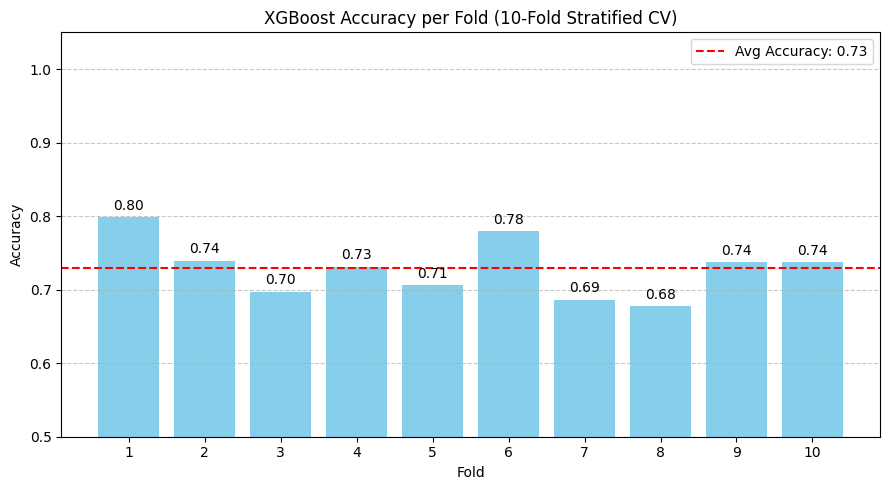

In [38]:
plt.figure(figsize=(9, 5))
bars = plt.bar(range(1, 11), fold_accuracies, color='skyblue')
plt.axhline(avg_acc, color='red', linestyle='--', label=f'Avg Accuracy: {avg_acc:.2f}')
plt.xticks(range(1, 11))
plt.ylim(0.5, 1.05)
plt.title("XGBoost Accuracy per Fold (10-Fold Stratified CV)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center', fontsize=10)

plt.legend()
plt.tight_layout()
plt.show()